### calculate_thai_income_tax

In [105]:
def calculate_thai_income_tax(net_assessable_income):
    tax = 0
    income = net_assessable_income

    # ตารางอัตราภาษี (ขั้นเงินได้สุทธิ, อัตราภาษี)
    brackets = [
        (150000, 0.00),  # 0 - 150,000 ยกเว้น
        (300000, 0.05),  # 150,001 - 300,000 ร้อยละ 5
        (500000, 0.10),  # 300,001 - 500,000 ร้อยละ 10
        (750000, 0.15),  # 500,001 - 750,000 ร้อยละ 15
        (1000000, 0.20), # 750,001 - 1,000,000 ร้อยละ 20
        (2000000, 0.25), # 1,000,001 - 2,000,000 ร้อยละ 25
        (5000000, 0.30), # 2,000,001 - 5,000,000 ร้อยละ 30
        (float('inf'), 0.35) # 5,000,001 ขึ้นไป ร้อยละ 35
    ]

    prev_limit = 0

    for limit, rate in brackets:
        if income <= prev_limit:
            break

        # ส่วนเงินได้ที่ตกอยู่ในขั้นนี้
        taxable_amount = min(income, limit) - prev_limit
        tax += taxable_amount * rate

        prev_limit = limit

    return tax

### optimize_dividend_tax    
    """
    ฟังก์ชันเปรียบเทียบ Final Tax vs ยื่นเครดิตภาษี
    
    base_net_income: เงินได้สุทธิจากงานประจำ/ธุรกิจ (หลังหักลดหย่อน) *ก่อน* รวมปันผล
    dividend_amount: เงินปันผลที่ได้รับ (ก่อนหัก ณ ที่จ่าย)
    corporate_tax_rate: อัตราภาษีของบริษัทหุ้นที่จ่ายปันผล (เช่น 20, 30)
    """

In [106]:
def optimize_dividend_tax(base_net_income, dividend_amount, corporate_tax_rate):
    """
    ฟังก์ชันเปรียบเทียบ Final Tax vs ยื่นเครดิตภาษี

    base_net_income: เงินได้สุทธิจากงานประจำ/ธุรกิจ (หลังหักลดหย่อน) *ก่อน* รวมปันผล
    dividend_amount: เงินปันผลที่ได้รับ (ก่อนหัก ณ ที่จ่าย)
    corporate_tax_rate: อัตราภาษีของบริษัทหุ้นที่จ่ายปันผล (เช่น 20, 30)
    """

    # ทางเลือกที่ 1 : Final Tax (หัก ณ ที่จ่าย 10% แล้วจบ)
    withholding_tax = dividend_amount * 0.10
    net_received_final_tax = dividend_amount - withholding_tax

    # ภาษีจากรายได้อื่น (ไม่เอาปันผลมารวม)
    tax_base_case = calculate_thai_income_tax(base_net_income)

    # เงินเหลือสุทธิ (รายได้อื่นหลังภาษี + ปันผลหลังหัก 10%)
    total_net_wealth_option1 = (base_net_income - tax_base_case) + net_received_final_tax

    # ทางเลือกที่ 2 : Tax Credit (ยื่นรวมคำนวณ)
    # สูตรเครดิตภาษี = ปันผล x (ภาษีบริษัท / (100 - ภาษีบริษัท))
    if corporate_tax_rate > 0:
        tax_credit_ratio = corporate_tax_rate / (100 - corporate_tax_rate)
        tax_credit_value = dividend_amount * tax_credit_ratio
    else:
        tax_credit_value = 0 # กรณีบริษัทได้รับการยกเว้นภาษี (BOI) จะไม่มีเครดิต

    # รายได้ปันผลที่จะนำไปคิดภาษี = ปันผลรับจริง + เครดิตภาษี (Grossed-up)
    gross_dividend_income = dividend_amount + tax_credit_value

    # เงินได้สุทธิรวมใหม่ (งานประจำ + ปันผล Grossed-up)
    total_net_income_option2 = base_net_income + gross_dividend_income

    # คำนวณภาษีใหม่
    total_tax_liability = calculate_thai_income_tax(total_net_income_option2)

    # ภาษีที่ต้องจ่ายจริง = ภาษีคำนวณใหม่ - เครดิตภาษีปันผล - ภาษีหัก ณ ที่จ่าย 10% (ที่โดนหักไปแล้ว)
    # แต่ในที่นี้เราดูแค่ Wealth สุทธิ จึงเอา (รายได้รวม - ภาษีคำนวณใหม่)
    # *Note: เครดิตภาษีถือเป็นเงินที่เรา "จ่ายไปแล้ว" ทางอ้อม จึงเอามาหักออกจากภาระภาษีได้

    total_net_wealth_option2 = (base_net_income + gross_dividend_income) - total_tax_liability

    # --- เปรียบเทียบผลลัพธ์ ---
    diff = total_net_wealth_option2 - total_net_wealth_option1

    result = {
        "dividend_received": dividend_amount,
        "cit_rate": corporate_tax_rate,
        "option1_final_tax_wealth": round(total_net_wealth_option1, 2),
        "option2_credit_tax_wealth": round(total_net_wealth_option2, 2),
        "difference": round(diff, 2),
        "recommendation": "",
        "reason": ""
    }

    if diff > 0:
        result["recommendation"] = "✅ ควรยื่นภาษี (ขอเครดิต)"
        result["reason"] = f"คุณจะได้เงินเพิ่มขึ้น {diff:,.2f} บาท (เพราะฐานภาษีคุณต่ำกว่าภาษีบริษัท)"
    else:
        result["recommendation"] = "🛑 เลือก Final Tax (หัก 10% จบ)"
        result["reason"] = f"ถ้าขอยื่นคุณจะเสียเงินเพิ่ม {-diff:,.2f} บาท (เพราะฐานภาษีคุณสูงแล้ว)"

    return result

# ==========================================
#  ส่วนทดสอบระบบ (User Test)
# ==========================================

# 1. ข้อมูลผู้ใช้ (สมมติ)
user_net_income = 240000

# 2. ข้อมูลหุ้น (สมมติหุ้น PTT)
dividend_amount = 10000  # ได้ปันผลมา 10,000 บาท
company_cit = 20         # บริษัทเสียภาษี 20%

# 3. คำนวณ
analysis = optimize_dividend_tax(user_net_income, dividend_amount, company_cit)

# 4. แสดงผล
print(f"--- ผลการวิเคราะห์การยื่นภาษี ---")
print(f"เงินได้สุทธิเดิมของคุณ: {user_net_income:,} บาท")
print(f"ได้รับปันผล: {dividend_amount:,} บาท (จากบริษัทที่เสียภาษี {company_cit}%)")
print("-" * 30)
print(f"ทางเลือก 1 (Final Tax): เงินเหลือเข้ากระเป๋าจริง = {analysis['option1_final_tax_wealth']:,} บาท")
print(f"ทางเลือก 2 (ยื่นเครดิต): เงินเหลือเข้ากระเป๋าจริง = {analysis['option2_credit_tax_wealth']:,} บาท")
print("-" * 30)
print(f"สรุป: {analysis['recommendation']}")
print(f"เหตุผล: {analysis['reason']}")

--- ผลการวิเคราะห์การยื่นภาษี ---
เงินได้สุทธิเดิมของคุณ: 240,000 บาท
ได้รับปันผล: 10,000 บาท (จากบริษัทที่เสียภาษี 20%)
------------------------------
ทางเลือก 1 (Final Tax): เงินเหลือเข้ากระเป๋าจริง = 244,500.0 บาท
ทางเลือก 2 (ยื่นเครดิต): เงินเหลือเข้ากระเป๋าจริง = 247,375.0 บาท
------------------------------
สรุป: ✅ ควรยื่นภาษี (ขอเครดิต)
เหตุผล: คุณจะได้เงินเพิ่มขึ้น 2,875.00 บาท (เพราะฐานภาษีคุณต่ำกว่าภาษีบริษัท)


# Scoring

## Factor1_T-DTS

In [107]:
! pip install yfinance

In [108]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz

# 1. รายชื่อหุ้น SET50 
set50_tickers = [
    "ADVANC.BK","AOT.BK","AWC.BK","BANPU.BK","BBL.BK","BDMS.BK","BEM.BK","BGRIM.BK","BH.BK","BJC.BK",
    "BPP.BK","CPALL.BK","CPF.BK","CPN.BK","CRC.BK","DELTA.BK","EGCO.BK","ESSO.BK","GULF.BK","HMPRO.BK",
    "IRPC.BK","KBANK.BK","KTB.BK","KTC.BK","LH.BK","MINT.BK","MTC.BK","OR.BK","OSP.BK",
    "PTT.BK","PTTEP.BK","PTTGC.BK","RATCH.BK","SAWAD.BK","SCB.BK","SCC.BK","SCGP.BK","TISCO.BK","TLI.BK",
    "TOP.BK","TTB.BK","TU.BK","VGI.BK","WHA.BK","GLOBAL.BK","BAM.BK","CPAXT.BK","GPSC.BK","BLA.BK"
]

def analyze_tdts_history(tickers, start_year=2022, end_year=2024):
    all_data = []
    print(f"กำลังดึงข้อมูลย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            # ดึงข้อมูลหุ้น
            stock = yf.Ticker(symbol)

            # 1. ดึงประวัติราคา (ย้อนหลังเผื่อไว้หน่อย)
            # ดึงตั้งแต่ต้นปี start_year ถึงปัจจุบัน
            history = stock.history(start=f"{start_year}-01-01", end=f"{end_year+1}-12-31")

            # 2. ดึงประวัติปันผล
            dividends = stock.dividends

            # แปลง timezone ให้ตรงกัน (เพื่อเทียบวันที่)
            if not history.empty:
                history.index = history.index.normalize() # ตัดเวลาออกเหลือแค่วันที่

            if not dividends.empty:
                 dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการ
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 3. วนลูปคำนวณ T-DTS สำหรับการจ่ายปันผล "แต่ละครั้ง"
            for date, amount in target_dividends.items():
                # วันที่จ่ายปันผลใน yfinance คือ Ex-Date
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลราคาในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หา Index ของวัน Ex-Date
                loc_ex = history.index.get_loc(ex_date)

                # ถ้าเป็นวันแรกของข้อมูล จะไม่มี Cum Date (วันก่อนหน้า)
                if loc_ex == 0:
                    continue

                # วัน Cum Date คือวันทำการก่อนหน้า Ex-Date 1 วัน
                loc_cum = loc_ex - 1

                # ดึงข้อมูลราคาปิด (Close Price)
                p_ex = history.iloc[loc_ex]['Close']
                p_cum = history.iloc[loc_cum]['Close']
                date_cum = history.index[loc_cum]

                # --- คำนวณสูตร T-DTS ---
                # Dividend Yield (DY)
                dy = (amount / p_cum) * 100

                # Price Drop (PD)
                pd_pct = ((p_cum - p_ex) / p_cum) * 100

                # T-DTS
                if dy != 0:
                    t_dts = pd_pct / dy
                else:
                    t_dts = 0

                # เก็บข้อมูลลง List
                all_data.append({
                    'Stock': symbol.replace('', ''),
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS (Baht)': amount,
                    'P_cum': p_cum,
                    'P_ex': p_ex,
                    'DY (%)': dy,
                    'PD (%)': pd_pct,
                    'T-DTS': t_dts
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame
    df = pd.DataFrame(all_data)

    # เรียงลำดับตาม ชื่อหุ้น -> ปี -> วันที่
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
df_results_T_DTS = analyze_tdts_history(set50_tickers)
df_results_T_DTS

กำลังดึงข้อมูลย้อนหลังปี 2022-2024 ...


$ESSO.BK: possibly delisted; no timezone found
$ESSO.BK: possibly delisted; no timezone found


Error checking ESSO.BK: 'RangeIndex' object has no attribute 'year'


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021667,203.775391,1.989835,-1.369864,-0.688431
2,ADVANC.BK,2023,2023-02-22,4.2400,185.480789,187.500031,2.285951,-1.088653,-0.476236
1,ADVANC.BK,2022,2022-08-19,3.4500,173.601196,173.115402,1.987313,0.279833,0.140810
...,...,...,...,...,...,...,...,...,...
202,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358184,-0.531775
201,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481166,1.495003,-0.139879,-0.093564
200,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006744,-0.002672
199,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186841,-0.090271


In [109]:
df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]

C:\Users\natta\AppData\Local\Temp\ipykernel_2828\3432150815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
153,SCB.BK,2023,2023-09-13,2.50,95.108749,95.527733,2.628570,-0.440531,-0.167593
152,SCB.BK,2023,2023-04-17,5.19,82.244469,83.220161,6.310455,-1.186332,-0.187995


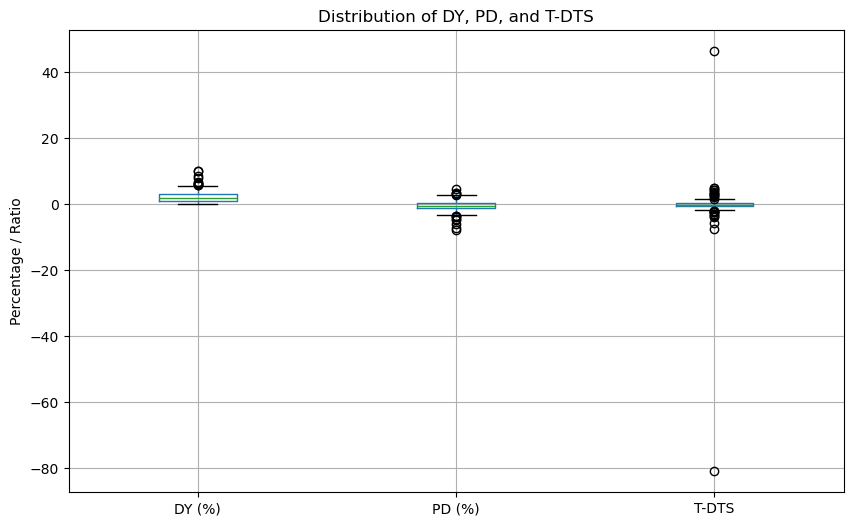

In [110]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_results_T_DTS[['DY (%)', 'PD (%)', 'T-DTS']].boxplot()

plt.title("Distribution of DY, PD, and T-DTS")
plt.ylabel("Percentage / Ratio")
plt.show()

In [111]:
# หาตัวการที่ทำให้กราฟเบี้ยว
outlier = df_results_T_DTS[(df_results_T_DTS['T-DTS'] < -10) | (df_results_T_DTS['T-DTS'] > 10)]
outlier

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
34,BGRIM.BK,2023,2023-03-14,0.035000,36.166206,34.543152,0.096775,4.487765,46.372986
150,SAWAD.BK,2024,2024-05-08,0.010455,33.019634,33.865894,0.031663,-2.562900,-80.943096


In [112]:
df_results_T_DTS_clean = df_results_T_DTS.drop(outlier.index)
df_results_T_DTS_clean

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021667,203.775391,1.989835,-1.369864,-0.688431
2,ADVANC.BK,2023,2023-02-22,4.2400,185.480789,187.500031,2.285951,-1.088653,-0.476236
1,ADVANC.BK,2022,2022-08-19,3.4500,173.601196,173.115402,1.987313,0.279833,0.140810
...,...,...,...,...,...,...,...,...,...
202,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358184,-0.531775
201,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481166,1.495003,-0.139879,-0.093564
200,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006744,-0.002672
199,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186841,-0.090271


# Factor2_bf_af_avg


In [113]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def calculate_tema(series, span):
    """ฟังก์ชันช่วยคำนวณ TEMA (Triple Exponential Moving Average)"""
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    ema3 = ema2.ewm(span=span, adjust=False).mean()
    return (3 * ema1) - (3 * ema2) + ema3

def analyze_xd_tema_history(tickers, start_year=2022, end_year=2024, window=15):
    all_data = []
    print(f"กำลังดึงข้อมูลและคำนวณ TEMA({window}) ย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            stock = yf.Ticker(symbol)

            # 1. ดึงข้อมูลย้อนหลัง (เผื่อ Buffer ให้ TEMA ทำงานเสถียรหน่อย จึงลบ start_year ไปอีก 1 ปี)
            # เช่น อยากได้ 2022 ให้ดึงตั้งแต่ 2021
            fetch_start = f"{start_year - 1}-01-01" 
            history = stock.history(start=fetch_start, end=f"{end_year+1}-12-31")
            dividends = stock.dividends

            if history.empty:
                continue

            # 2. คำนวณ TEMA เตรียมไว้ใน DataFrame เลย
            history['TEMA'] = calculate_tema(history['Close'], span=window)

            # 3. จัดการ Timezone ให้ตรงกัน
            history.index = history.index.normalize()
            if not dividends.empty:
                dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการวิเคราะห์
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 4. วนลูปวิเคราะห์เหตุการณ์ XD แต่ละครั้ง
            for date, amount in target_dividends.items():
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หาตำแหน่ง Index ของวัน XD
                loc_xd = history.index.get_loc(ex_date)

                # --- Boundary Check ---
                # ตรวจสอบว่าข้อมูลมีเพียงพอสำหรับ Window หน้าและหลังหรือไม่
                # ต้องมีข้อมูลย้อนหลัง window วัน และมีข้อมูลล่วงหน้า window วัน
                if (loc_xd - window < 0) or (loc_xd + window >= len(history)):
                    continue

                # --- ดึงค่า TEMA ที่ตำแหน่งต่างๆ ---
                # loc_xd - window : จุดเริ่มต้นช่วงก่อน XD
                # loc_xd - 1      : วันทำการก่อน XD (Pre-XD)
                # loc_xd          : วัน XD
                # loc_xd + window : จุดสิ้นสุดช่วงหลัง XD
                
                tema_prev_win = history.iloc[loc_xd - window]['TEMA']
                tema_pre_xd   = history.iloc[loc_xd - 1]['TEMA']
                tema_xd       = history.iloc[loc_xd]['TEMA']
                tema_post_win = history.iloc[loc_xd + window]['TEMA']
                
                actual_price_xd = history.iloc[loc_xd]['Close']

                # --- คำนวณ Return โดยใช้ค่า TEMA ---
                # Ret_Bf: TEMA เปลี่ยนแปลงเท่าไหร่ในช่วง Window ก่อนถึงวัน XD
                ret_bf = ((tema_pre_xd - tema_prev_win) / tema_prev_win) * 100

                # Ret_Af: TEMA เปลี่ยนแปลงเท่าไหร่หลังจากวัน XD ไปจนจบ Window
                ret_af = ((tema_post_win - tema_xd) / tema_xd) * 100

                # เก็บข้อมูล
                all_data.append({
                    'Stock': symbol.replace('.BK', ''), # ตัด .BK ออกให้ดูสะอาดตา
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS': amount,
                    'Price_Close': round(actual_price_xd, 2),
                    'Price_TEMA': round(tema_xd, 2),
                    'Ret_Bf_TEMA (%)': round(ret_bf, 2),
                    'Ret_Af_TEMA (%)': round(ret_af, 2)
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame และเรียงข้อมูล
    df = pd.DataFrame(all_data)
    
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
# window=15 หมายถึง ดูย้อนหลัง 15 วัน และ ไปข้างหน้า 15 วัน (และใช้คำนวณ TEMA 15 ด้วย)
df_results_tema = analyze_xd_tema_history(set50_tickers, start_year=2022, end_year=2024, window=15)


# ตัวอย่างการดูเฉพาะหุ้น CPALL
df_results_tema[df_results_tema['Stock'] == 'CPALL']

กำลังดึงข้อมูลและคำนวณ TEMA(15) ย้อนหลังปี 2022-2024 ...


$ESSO.BK: possibly delisted; no timezone found
$ESSO.BK: possibly delisted; no timezone found


,Stock,Year,Ex-Date,DPS,Price_Close,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
58,CPALL,2024,2024-05-07,1.00,56.72,56.03,4.99,1.24
57,CPALL,2023,2023-05-02,0.75,61.72,61.48,4.39,-2.70
56,CPALL,2022,2022-04-28,0.60,61.95,61.80,2.06,-1.78


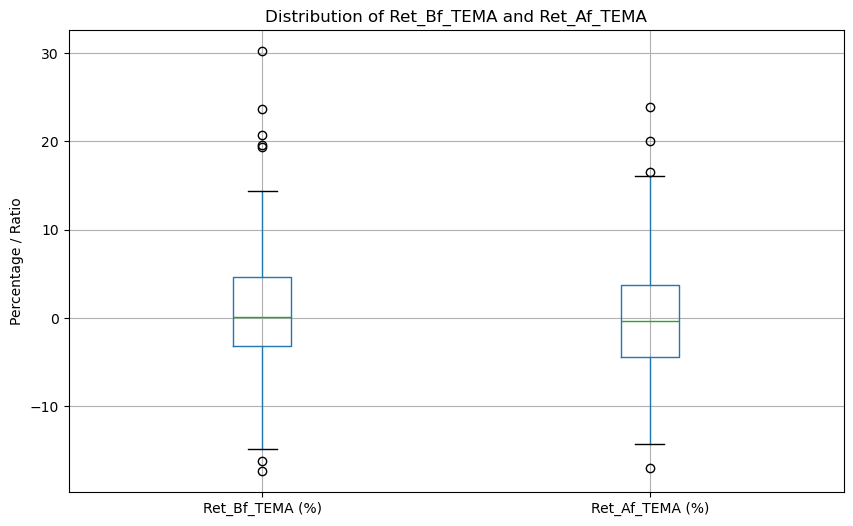

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_results_tema[['Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']].boxplot()

plt.title("Distribution of Ret_Bf_TEMA and Ret_Af_TEMA")
plt.ylabel("Percentage / Ratio")
plt.show()

## Merge (TEMA + T-DTS)

In [115]:
import pandas as pd

# สมมติว่าคุณมี DataFrame 2 ตัวชื่อ df_tdts และ df_tema
df_tdts = df_results_T_DTS_clean
df_tema = df_results_tema

# --- ขั้นตอนที่ 1: จัด Format ชื่อหุ้นให้ตรงกัน ---
# ลบ .BK ออกจาก df_tdts เพื่อให้เหมือนกับ df_tema
df_tdts['Stock'] = df_tdts['Stock'].str.replace('.BK', '')

# --- ขั้นตอนที่ 2: แปลงวันที่ให้เป็น datetime object (เพื่อความชัวร์) ---
df_tdts['Ex-Date'] = pd.to_datetime(df_tdts['Ex-Date'])
df_tema['Ex-Date'] = pd.to_datetime(df_tema['Ex-Date'])

# --- ขั้นตอนที่ 3: เลือกเฉพาะคอลัมน์จาก TEMA ที่ต้องการมารวม ---
# เราไม่เอา Year หรือ DPS ซ้ำ เพราะใน T-DTS มีอยู่แล้ว
cols_to_use = ['Stock', 'Ex-Date', 'Price_TEMA', 'Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']
df_tema_subset = df_tema[cols_to_use]

# --- ขั้นตอนที่ 4: สั่ง Merge ---
# ใช้ key คือ 'Stock' และ 'Ex-Date' ตรงกัน
df_merged = pd.merge(
    df_tdts, 
    df_tema_subset, 
    on=['Stock', 'Ex-Date'], 
    how='inner'  # inner = เอาเฉพาะแถวที่ข้อมูลชนกันเจอทั้งคู่ (แนะนำ), left = ยึด T-DTS เป็นหลัก
)

# แสดงผล
df_merged

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
0,ADVANC,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563,231.77,9.00,9.26
1,ADVANC,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146,194.93,-2.03,1.12
2,ADVANC,2023,2023-08-18,4.0000,201.021667,203.775391,1.989835,-1.369864,-0.688431,201.25,-0.51,-2.28
3,ADVANC,2023,2023-02-22,4.2400,185.480789,187.500031,2.285951,-1.088653,-0.476236,187.18,6.55,-1.22
4,ADVANC,2022,2022-08-19,3.4500,173.601196,173.115402,1.987313,0.279833,0.140810,173.75,-0.13,-2.34
...,...,...,...,...,...,...,...,...,...,...,...,...
215,WHA,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358184,-0.531775,4.65,5.82,8.65
216,WHA,2023,2023-11-22,0.0669,4.474906,4.481166,1.495003,-0.139879,-0.093564,4.45,-1.84,3.67
217,WHA,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006744,-0.002672,3.99,1.74,0.27
218,WHA,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186841,-0.090271,3.26,-3.20,4.90


In [116]:
df_agg = df_merged.groupby('Stock').aggregate({'DY (%)': 'mean', 'T-DTS': 'mean', 'Ret_Af_TEMA (%)': 'mean', 'Ret_Bf_TEMA (%)': 'mean'})
df_agg

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%)
Stock,,,,
ADVANC,2.141122,-0.427356,0.513333,3.273333
AOT,0.951026,-0.677177,1.945000,-6.145000
AWC,0.680557,1.436632,-6.493333,-3.363333
BAM,4.049142,0.272653,-8.546667,-3.083333
BANPU,4.399007,-0.247805,1.763333,2.845000
BBL,2.072059,-0.492391,1.655000,2.365000
BDMS,1.185160,-1.316281,2.578333,2.428333
BEM,1.384812,-0.166353,-1.746667,1.460000
BGRIM,0.607163,-0.014765,1.982000,-5.078000


d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

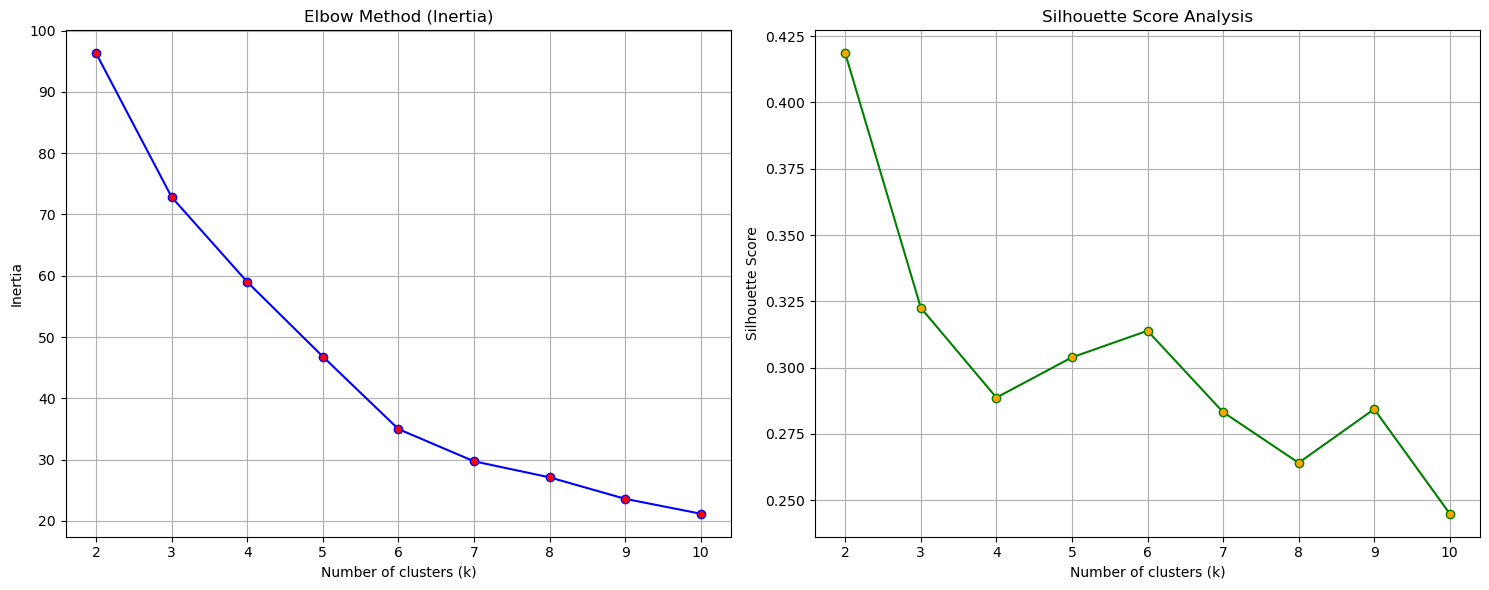

    k    Inertia  Silhouette Score
0   2  96.301099          0.418479
1   3  72.829387          0.322567
2   4  58.985669          0.288712
3   5  46.810186          0.303877
4   6  34.976128          0.313900
5   7  29.719287          0.283228
6   8  27.099350          0.264122
7   9  23.592900          0.284369
8  10  21.161561          0.244941


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ลบแถวที่มี NaN (ถ้ามี) เพื่อไม่ให้ error
df_clustering = df_agg.dropna().copy()

# กำหนด Features ที่จะใช้
features = ['T-DTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']
X = df_clustering[features]

# Standardize ข้อมูล (ปรับสเกลให้ mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. คำนวณ Inertia และ Silhouette Score สำหรับ k ต่างๆ
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)  # ลองแบ่งกลุ่มตั้งแต่ 2 ถึง 10 กลุ่ม

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # เก็บค่า Inertia (Sum of squared distances of samples to their closest cluster center)
    inertia_values.append(kmeans.inertia_)
    
    # เก็บค่า Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 3. พล็อตกราฟแสดงผล
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# กราฟ Elbow Method (Inertia)
ax1.plot(k_range, inertia_values, 'bo-', markerfacecolor='red')
ax1.set_title('Elbow Method (Inertia)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# กราฟ Silhouette Score
ax2.plot(k_range, silhouette_scores, 'go-', markerfacecolor='orange')
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# แสดงค่า Score แบบตารางเพื่อให้ดูง่าย
df_scores = pd.DataFrame({
    'k': k_range,
    'Inertia': inertia_values,
    'Silhouette Score': silhouette_scores
})
print(df_scores)

d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


=== K-Means Clustering (k=4) Results ===
Inertia: 58.99
Silhouette Score: 0.2887

=== Cluster Summary ===
   Cluster     T-DTS  Ret_Af_TEMA (%)  Ret_Bf_TEMA (%)  Count
0        0 -0.359683         2.369863        -3.027935      8
1        1 -0.615966         2.334357         2.975869     14
2        2  0.013324        -1.737767         1.439700     20
3        3  1.211919        -4.797917        -4.441042      4


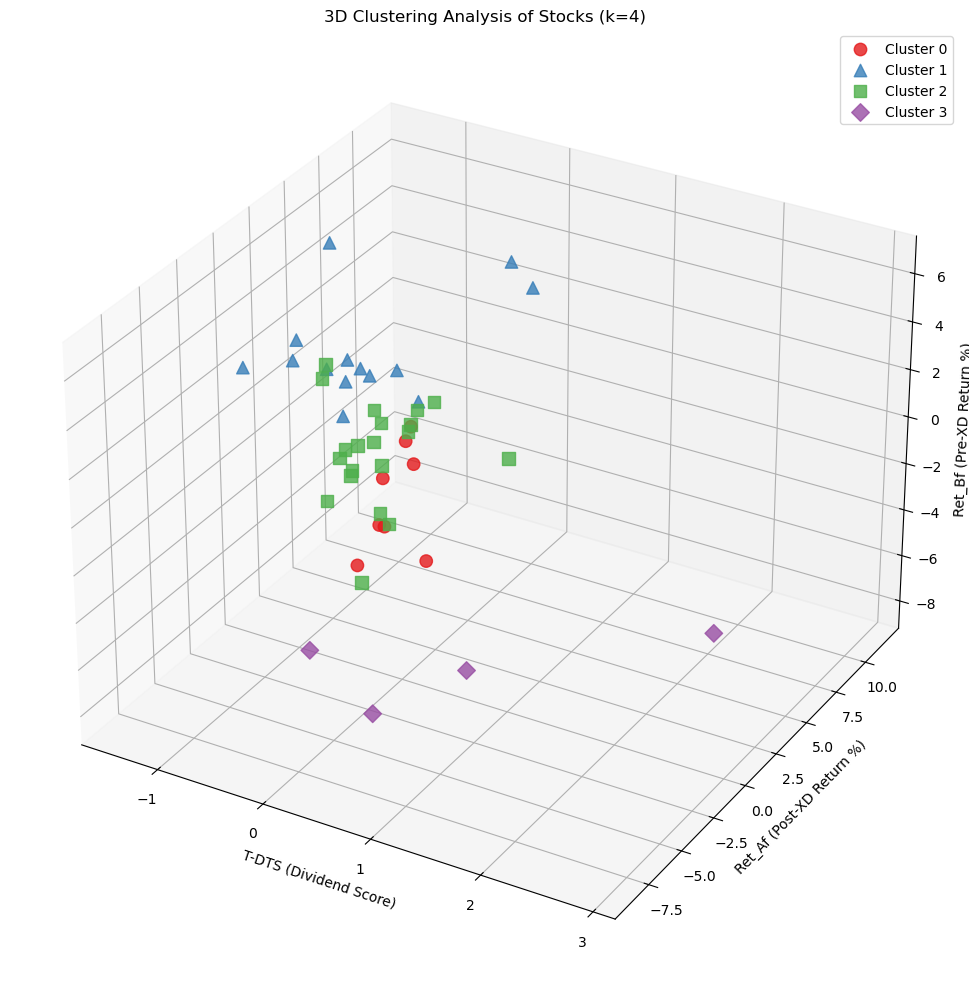

--------------------------------------------------

Cluster 0 (8 stocks):
AOT, BGRIM, BLA, CPN, MTC, OSP, SCC, WHA

Cluster 1 (14 stocks):
ADVANC, BANPU, BBL, BDMS, BH, BJC, CPALL, CPF, GLOBAL, KTB, MINT, PTTEP, SCB, TLI

Cluster 2 (20 stocks):
BEM, BPP, CRC, EGCO, GPSC, HMPRO, IRPC, KBANK, KTC, LH, OR, PTT, PTTGC, RATCH, SAWAD

Cluster 3 (4 stocks):
AWC, BAM, DELTA, VGI


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # จำเป็นสำหรับ 3D Plot
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ใช้ df_agg ที่คุณ aggregate มาแล้ว
df_model = df_agg.dropna().copy()
features = ['T-DTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']

# Standardize ข้อมูล (ปรับสเกลให้เป็นมาตรฐานเดียวกัน)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

# 2. สร้างโมเดล K-Means (k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_model['Cluster'] = kmeans.fit_predict(X_scaled)

# คำนวณ Score เพื่อดูคุณภาพ
inertia = kmeans.inertia_
sil_score = silhouette_score(X_scaled, df_model['Cluster'])

print(f"=== K-Means Clustering (k={k}) Results ===")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")

# ดูค่าเฉลี่ยของแต่ละกลุ่ม (Centroids)
cluster_summary = df_model.groupby('Cluster')[features].mean().reset_index()
cluster_summary['Count'] = df_model.groupby('Cluster')['T-DTS'].count().values
print("\n=== Cluster Summary ===")
print(cluster_summary)

# 3. สร้างกราฟ 3D Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# กำหนดสีสำหรับ 4 กลุ่ม
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Red, Blue, Green, Purple
markers = ['o', '^', 's', 'D']

for cluster_id in range(k):
    subset = df_model[df_model['Cluster'] == cluster_id]
    ax.scatter(
        subset['T-DTS'], 
        subset['Ret_Af_TEMA (%)'], 
        subset['Ret_Bf_TEMA (%)'], 
        c=colors[cluster_id],
        marker=markers[cluster_id],
        s=80,      # ขนาดจุด
        alpha=0.8, # ความโปร่งใส
        label=f'Cluster {cluster_id}'
    )

# ตั้งชื่อแกน
ax.set_xlabel('T-DTS (Dividend Score)')
ax.set_ylabel('Ret_Af (Post-XD Return %)')
ax.set_zlabel('Ret_Bf (Pre-XD Return %)')
ax.set_title(f'3D Clustering Analysis of Stocks (k={k})')

# มุมมอง (สามารถปรับหมุนได้ถ้าทำใน Notebook Interactive)
# ax.view_init(elev=20, azim=45) 

plt.legend()
plt.tight_layout()
plt.show()

# 4. (แถม) แสดงรายชื่อหุ้นในแต่ละกลุ่ม
print("-" * 50)
for i in range(k):
    stocks = df_model[df_model['Cluster'] == i].index.tolist()
    print(f"\nCluster {i} ({len(stocks)} stocks):")
    print(", ".join(stocks[:15])) # โชว์แค่ 15 ตัวแรก

In [119]:
df_model
df_scoring = df_model.copy()
df_scoring['Total_Score (%)'] = (df_scoring['DY (%)'] * (1 - df_scoring['T-DTS']))\
      + df_scoring['Ret_Af_TEMA (%)']
df_scoring

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Cluster,Total_Score (%)
Stock,,,,,,
ADVANC,2.141122,-0.427356,0.513333,3.273333,1,3.569477
AOT,0.951026,-0.677177,1.945000,-6.145000,0,3.540038
AWC,0.680557,1.436632,-6.493333,-3.363333,3,-6.790486
BAM,4.049142,0.272653,-8.546667,-3.083333,3,-5.601535
BANPU,4.399007,-0.247805,1.763333,2.845000,1,7.252437
BBL,2.072059,-0.492391,1.655000,2.365000,1,4.747323
BDMS,1.185160,-1.316281,2.578333,2.428333,1,5.323496
BEM,1.384812,-0.166353,-1.746667,1.460000,2,-0.131487
BGRIM,0.607163,-0.014765,1.982000,-5.078000,0,2.598127


In [120]:
# สร้าง Dictionary สำหรับ map ชื่อกลุ่มตามที่วิเคราะห์
cluster_names = {
    0: 'Rebound Star (Buy on Dip)',     # ลงก่อน XD -> เด้งหลัง XD (คุ้ม)
    1: 'Golden Goose (Strong Trend)',   # ขึ้นตลอดทาง (คุ้มที่สุด)
    2: 'Sell on Fact (Neutral)',        # เสมอตัว -> เริ่มไหลลง (ขายทำกำไร)
    3: 'Dividend Trap (Avoid)'          # ลงตลอดทาง (ขาดทุนยับ)
}

# เพิ่มชื่อกลุ่มลงในตารางสรุป (cluster_summary)
df_scoring['Cluster_Name'] = df_scoring['Cluster'].map(cluster_names)


df_scoring

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Cluster,Total_Score (%),Cluster_Name
Stock,,,,,,,
ADVANC,2.141122,-0.427356,0.513333,3.273333,1,3.569477,Golden Goose (Strong Trend)
AOT,0.951026,-0.677177,1.945000,-6.145000,0,3.540038,Rebound Star (Buy on Dip)
AWC,0.680557,1.436632,-6.493333,-3.363333,3,-6.790486,Dividend Trap (Avoid)
BAM,4.049142,0.272653,-8.546667,-3.083333,3,-5.601535,Dividend Trap (Avoid)
BANPU,4.399007,-0.247805,1.763333,2.845000,1,7.252437,Golden Goose (Strong Trend)
BBL,2.072059,-0.492391,1.655000,2.365000,1,4.747323,Golden Goose (Strong Trend)
BDMS,1.185160,-1.316281,2.578333,2.428333,1,5.323496,Golden Goose (Strong Trend)
BEM,1.384812,-0.166353,-1.746667,1.460000,2,-0.131487,Sell on Fact (Neutral)
BGRIM,0.607163,-0.014765,1.982000,-5.078000,0,2.598127,Rebound Star (Buy on Dip)
